In [17]:
import importlib

import data_loading as load
import data_preprocessing as pre
import metrics
importlib.reload(metrics)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
input_func_list = [pre.normalize_pixels]
truth_func_list = [pre.invert, pre.to_grayscale, pre.normalize_pixels]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_ground-truth")
test_ds = ds_factory("./data/test_input", "./data/test_ground-truth")

Found 2000 files belonging to 1 classes.
Found 2000 files belonging to 1 classes.
Found 8400 files belonging to 1 classes.
Found 8400 files belonging to 1 classes.


In [18]:
simple_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(400, 275, 3)),

    tf.keras.layers.Conv2D(10, kernel_size=(3, 3), padding="valid", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Conv2D(50, kernel_size=(3, 3), padding="valid", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Conv2D(50, kernel_size=(3, 3), padding="valid", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(400*275, activation="sigmoid"),
    tf.keras.layers.Reshape((400, 275, 1))
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=metrics.SSIMLoss(),
    metrics=[metrics.PSNRMetric()]
)

simple_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (4, 398, 273, 10)         280       
                                                                 
 max_pooling2d_18 (MaxPoolin  (4, 132, 91, 10)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (4, 130, 89, 50)          4550      
                                                                 
 max_pooling2d_19 (MaxPoolin  (4, 43, 29, 50)          0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (4, 41, 27, 50)           22550     
                                                                 
 max_pooling2d_20 (MaxPoolin  (4, 13, 9, 50)          

In [19]:
history = simple_model.fit(train_ds, validation_data=test_ds)

500/500 [==============================] - ETA: 0s - loss: 0.9905 - psnr: 6.9259e-05

d:\conda\envs\fingerprints\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric PSNRMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


500/500 [==============================] - 2675s 5s/step - loss: 0.9905 - psnr: 6.9259e-05 - val_loss: 0.9900 - val_psnr: 7.0978e-05


In [28]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

n_examples = 4
fnames = np.random.choice(filenames, n_examples)
imgs_input = np.array([cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255
imgs_truth = np.array([cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255

1/1 [==============================] - 0s 229ms/step


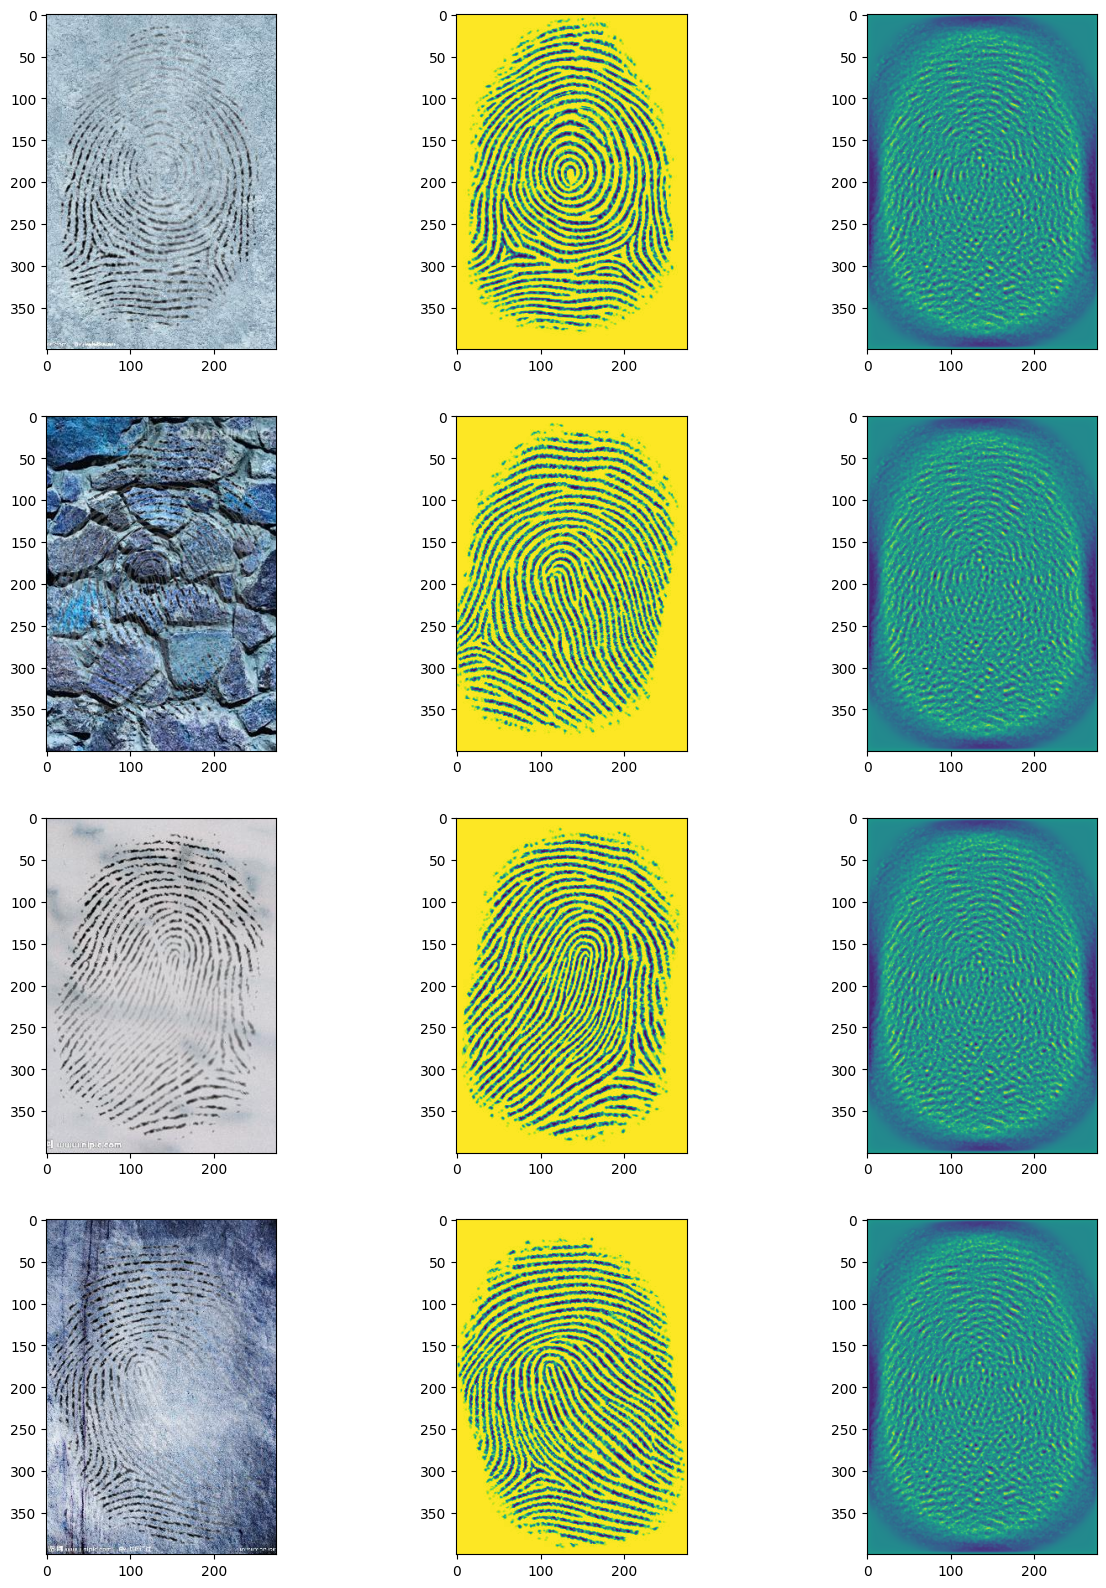

In [30]:
img_predict = simple_model.predict(imgs_input)


fig, axs = plt.subplots(n_examples, 3, figsize=(15, n_examples*5))
for i in range(n_examples):
    axs[i, 0].imshow(imgs_input[i])
    axs[i, 1].imshow(imgs_truth[i])
    axs[i, 2].imshow(img_predict[i])